### DATASET OVERVIEW

* **Gender**: male or female.
* **Age**: age of a person in years.
* **Height**: height in meters.
* **Weight**: weight in kilograms.
* **family_history_with_overweight**: whether the person has a family history with being overweight.
* **FAVC**: if the person frequently consumes high-caloric food (yes/no).
* **FCVC**: frequency of consumption of vegetables (scale from 1 to 3).
* **NCP**: number of main meals per day.
* **CAEC**: frequency of consuming food between meals (Never, Sometimes, Frequently, Always). 
* **SMOKE**: whether the person smokes (yes/no).
* **CH20**: daily water intake (scale from 1 to 3).
* **SCC**: if the person monitors their calorie intake (yes/no).
* **FAF**: frequency of physical activity (scale from 0 to 3).
* **TUE**: time spent using technology devices (scale from 0 to 3).
* **CALC**: frequency of alcohol consumption (Never, Sometimes, Frequently, Always).
* **MTRANS**: main mode of transportation (Car, Bike, Motorcycle, Public Transportation, Walking).
* **NObeyesedad**: obesity level (Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, Obesity Type III).

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore", 
                        category = FutureWarning)
print("Libraries imported.")

Libraries imported.


### READ AND EXPLORE DATA

In [2]:
data = pd.read_csv("ObesityDataSet2.csv")
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,24,1.58,65.29,yes,no,2.03,2.74,Sometimes,no,2.00,no,1.28,1.019,no,Public_Transportation,Overweight_Level_II
1,Male,23,1.65,66.00,no,no,3.00,3.00,Sometimes,no,2.00,no,3.00,0.000,no,Public_Transportation,Normal_Weight
2,Female,21,1.69,51.26,yes,yes,3.00,3.18,Frequently,no,1.91,no,0.48,0.625,no,Public_Transportation,Insufficient_Weight
3,Female,22,1.69,65.00,yes,yes,2.00,3.00,Sometimes,no,2.00,no,1.00,1.000,Sometimes,Public_Transportation,Normal_Weight
4,Female,23,1.61,82.64,yes,yes,2.96,1.00,Sometimes,no,2.98,no,0.74,2.000,Sometimes,Public_Transportation,Obesity_Type_I


> Here, we have successfully read the *ObesityDataSet2.csv* dataset.

In [3]:
print("Dataset Information:")
data.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1056 non-null   object 
 1   Age                             1056 non-null   object 
 2   Height                          1056 non-null   float64
 3   Weight                          1056 non-null   float64
 4   family_history_with_overweight  1056 non-null   object 
 5   FAVC                            1056 non-null   object 
 6   FCVC                            1019 non-null   float64
 7   NCP                             1056 non-null   float64
 8   CAEC                            1056 non-null   object 
 9   SMOKE                           1056 non-null   object 
 10  CH2O                            1056 non-null   float64
 11  SCC                             1056 non-null   object 
 12  FAF          

> Based on the data information above, it is known that the *ObesityDataSet2.csv* dataset has 1056 records and 17 columns. It is also known that there are some NULL values in features such as **FCVC** and **MTRANS** which will be explored further in the [**MISSING VALUES**](#MISSING-VALUES) section.

### CARDINALITY CHECK

In [4]:
def check_unique_values(data):
    cardinal = pd.DataFrame({
        "column name": data.columns.tolist(),
        "data type": [data[c].dtype for c in data.columns],
        "unique values": [data[c].nunique() for c in data.columns],
        "values": [sorted(data[c].unique()) if pd.api.types.is_numeric_dtype(data[c]) or pd.api.types.is_datetime64_any_dtype(data[c]) else data[c].unique() for c in data.columns],
        "minimum value": [data[c].min() if pd.api.types.is_numeric_dtype(data[c]) or pd.api.types.is_datetime64_any_dtype(data[c]) else "-" for c in data.columns],
        "maximum value": [data[c].max() if pd.api.types.is_numeric_dtype(data[c]) or pd.api.types.is_datetime64_any_dtype(data[c]) else "-" for c in data.columns]
    })
    
    print("Cardinality Check Result:")
    display(cardinal)

check_unique_values(data)

Cardinality Check Result:


,column name,data type,unique values,values,minimum value,maximum value
0,Gender,object,2,"[Female, Male]",-,-
1,Age,object,46,"[24, 23, 21, 22, 26, 18, 25, 20, 32, 20 years,...",-,-
2,Height,float64,47,"[1.45, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55...",1.45,1.95
3,Weight,float64,715,"[39.0, 39.1, 39.7, 41.32, 41.45, 41.56, 41.67,...",39.0,173.0
4,family_history_with_overweight,object,2,"[yes, no]",-,-
5,FAVC,object,2,"[no, yes]",-,-
6,FCVC,float64,147,"[1.0, 1.04, 1.05, 1.06, 1.07, 1.08, 1.11, 1.12...",1.0,3.0
7,NCP,float64,194,"[1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07...",1.0,4.0
8,CAEC,object,4,"[Sometimes, Frequently, no, Always]",-,-
9,SMOKE,object,2,"[no, yes]",-,-


> Based on the cardinality check above, it is known that:
> - The **Gender**, **family_history_with_overweight**, **FAVC**, **CAEC**, **SMOKE**, **SCC**, **CALC**, **MTRANS**, and **NObeyesdad** columns are categorical columns, because the number of their unique values is relatively small.
> - The **Age** column should have a numerical data type, so there is a possibility of an error in the data entry, which will be checked later in the [**IDENTIFY INCONSISTENCIES**](#IDENTIFY-INCONSISTENCIES) section.
> - The **Height**, **Weight**, **FCVC**, **NCP**, **CH2O**, **FAF**, and **TUE** columns are numerical columns.

#### DIVIDE NUMERICAL AND CATEGORICAL COLUMN

In [5]:
cat = []
num = []

for i in data.columns:
    if 'int' in str(data[i].dtype) or 'float' in str(data[i].dtype):
        num.append(i)
    else:
        cat.append(i)

nums = "Age"
num.append(nums)
cat.remove(nums)

print(f'Categorical: {cat}')
print(f'Numeric: {num}')

Categorical: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Numeric: ['Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Age']


> In this section, I am dividing the categorical and numerical columns to ensure ease of further data exploration later on.

### IDENTIFY INCONSISTENCIES

In [6]:
for c in data.columns:
    print(data[c].value_counts(), 
          "\n")

Gender
Male      532
Female    524
Name: count, dtype: int64 

Age
21          128
23          118
18          107
26          102
19           79
22           73
20           69
24           42
17           36
25           35
30           29
31           29
38           23
27           21
33           19
34           15
32           14
29           13
16           12
37           11
39           11
28            9
41            9
35            9
40            8
21 years      4
55            3
44            3
36            2
46            2
19 years      2
45            2
23 years      2
22 years      2
42            2
33 years      1
48            1
51            1
43            1
17 years      1
15            1
26 years      1
36 years      1
20 years      1
25 years      1
14            1
Name: count, dtype: int64 

Height
1.75    63
1.70    62
1.65    51
1.76    50
1.62    44
1.63    43
1.60    41
1.71    38
1.72    36
1.69    35
1.77    34
1.80    33
1.64    33
1.66    33
1.61    

> Based on the inconsistency checking above, it is known that the **Age** column has inconsistent data, for instance, there are entries like "21 years", whereas the **Age** data should only be a numeric value. Therefore, this inconsistency needs to be handled.

#### HANDLE INCONSISTENCIES: AGE

In [7]:
data['Age'] = data['Age'].str.extract('(\d+)').astype(int)
print("Inconsistencies in Age column handled.")

Inconsistencies in Age column handled.


In [8]:
print(data["Age"].value_counts())

Age
21    132
23    120
18    107
26    103
19     81
22     75
20     70
24     42
17     37
25     36
30     29
31     29
38     23
27     21
33     20
34     15
32     14
29     13
16     12
39     11
37     11
41      9
28      9
35      9
40      8
36      3
44      3
55      3
45      2
46      2
42      2
15      1
43      1
51      1
48      1
14      1
Name: count, dtype: int64


> Here, the data inconsistency in the **Age** column has been successfully handled.

In [9]:
check_unique_values(data)

Cardinality Check Result:


,column name,data type,unique values,values,minimum value,maximum value
0,Gender,object,2,"[Female, Male]",-,-
1,Age,int32,36,"[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...",14,55
2,Height,float64,47,"[1.45, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55...",1.45,1.95
3,Weight,float64,715,"[39.0, 39.1, 39.7, 41.32, 41.45, 41.56, 41.67,...",39.0,173.0
4,family_history_with_overweight,object,2,"[yes, no]",-,-
5,FAVC,object,2,"[no, yes]",-,-
6,FCVC,float64,147,"[1.0, 1.04, 1.05, 1.06, 1.07, 1.08, 1.11, 1.12...",1.0,3.0
7,NCP,float64,194,"[1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07...",1.0,4.0
8,CAEC,object,4,"[Sometimes, Frequently, no, Always]",-,-
9,SMOKE,object,2,"[no, yes]",-,-


### DUPLICATED VALUES

In [10]:
print(f"There are {data.duplicated().sum()} duplicates.")

There are 10 duplicates.


> Based on the output above, it is known that the data has 10 duplicated entries, which will cause redundancy, so I will drop the duplicate data.

In [11]:
data = data.drop_duplicates().reset_index(drop = True)
print(f"Duplicates dropped.")
print(f"There are {data.duplicated().sum()} duplicates.")

Duplicates dropped.
There are 0 duplicates.


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1046 non-null   object 
 1   Age                             1046 non-null   int32  
 2   Height                          1046 non-null   float64
 3   Weight                          1046 non-null   float64
 4   family_history_with_overweight  1046 non-null   object 
 5   FAVC                            1046 non-null   object 
 6   FCVC                            1009 non-null   float64
 7   NCP                             1046 non-null   float64
 8   CAEC                            1046 non-null   object 
 9   SMOKE                           1046 non-null   object 
 10  CH2O                            1046 non-null   float64
 11  SCC                             1046 non-null   object 
 12  FAF                             10

> After dropping the duplicated values, the data I have now is 1046 entries.

### MISSING VALUES

In [13]:
def check_missing(data):
    missing = pd.DataFrame({
        "column name" : data.columns.tolist(),
        "missing values": data.isnull().sum().tolist(),
        "percentage": ((data.isnull().sum()) * 100 / len(data)).round(2).tolist()
    })

    print("Missing Values Check Result:")
    display(missing)

check_missing(data)

Missing Values Check Result:


,column name,missing values,percentage
0,Gender,0,0.00
1,Age,0,0.00
2,Height,0,0.00
3,Weight,0,0.00
4,family_history_with_overweight,0,0.00
5,FAVC,0,0.00
6,FCVC,37,3.54
7,NCP,0,0.00
8,CAEC,0,0.00
9,SMOKE,0,0.00


> Based on the missing values check above, it's confirmed that the **FCVC** and **MTRANS** columns have missing values, which aligns with the insight I found in the [**READ AND EXPLORE DATA**](#READ-AND-EXPLORE-DATA) section.  
> Generally, missing values with low percentages like 3.54 and 2.49 can be directly imputed. This is especially true considering the dataset is relatively small, where dropping rows with missing values could lead to the loss of valuable data.  
> To determine a suitable imputation method for this case, I will perform plotting to identify the positions of the data with missing values.

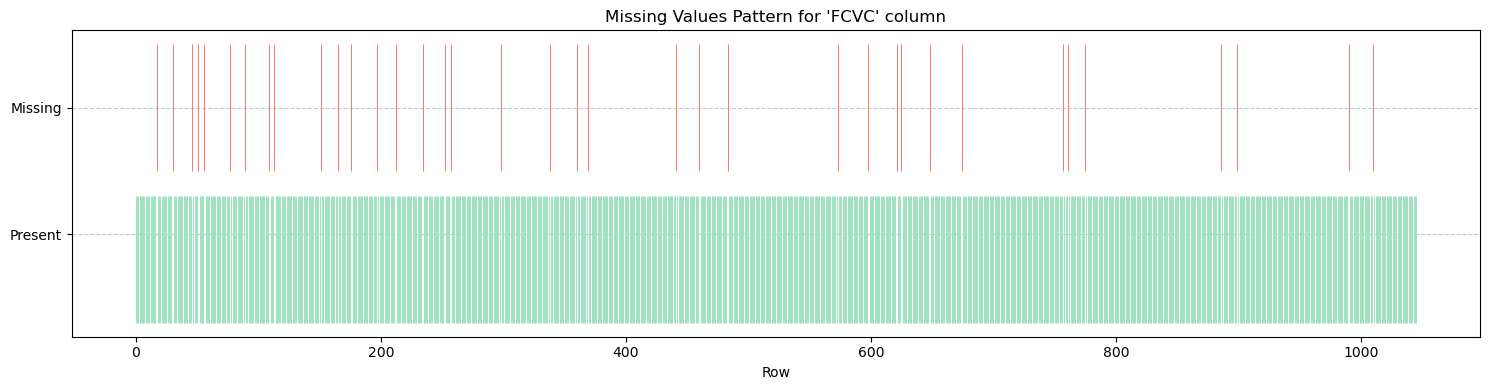

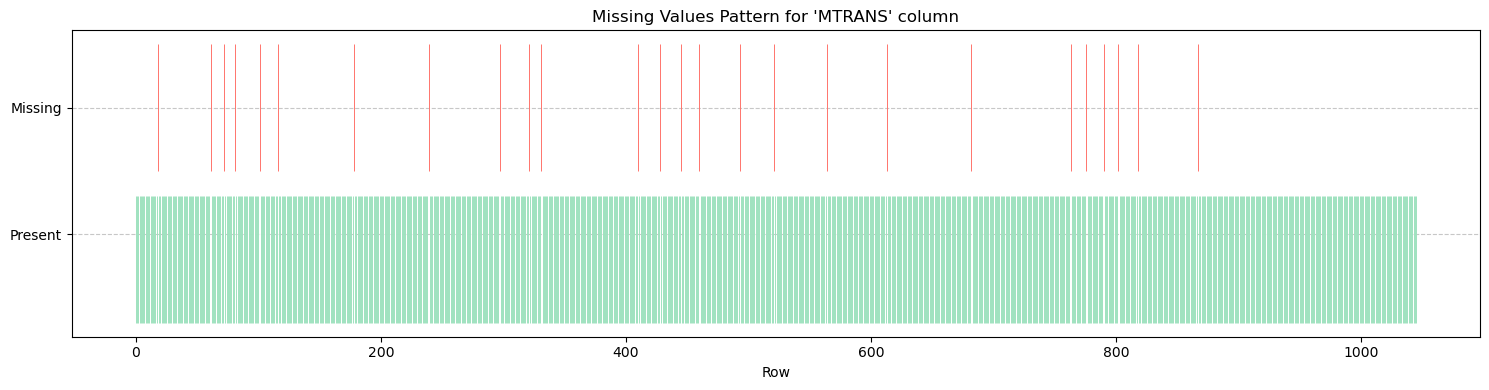

In [14]:
def na_pattern_plot(data, column, figsize = (15, 4)):
    na_mask = data[column].isna()
    fig, ax = plt.subplots(figsize = figsize)
    ax.vlines(data.index[na_mask], 
              ymin = 0.5, 
              ymax = 1.5, 
              linewidth = 0.7,
              colors = "#FF746C", 
              label = "Missing")
    ax.vlines(data.index[~na_mask],
              ymin = -0.7,
              ymax = 0.3,
              linewidth = 0.7,
              colors = "#9FE2BF",
              label = "Present")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Present", "Missing"])
    ax.set_xlabel("Row")
    ax.set_title(f"Missing Values Pattern for '{column}' column")
    ax.grid(True,
            axis = "y",
            linestyle = "--",
            alpha = 0.7)
    plt.tight_layout()
    plt.show()

for miss_cols in data.columns[data.isna().any()]:
    na_pattern_plot(data, 
                    miss_cols)

> Based on the missing value plot above, it is known that the missing entries in the data are random or have no specific patterns. Therefore, I will perform imputation with:
> - **Mode** for the categorical column (**MTRANS**).
> - **Median** or **Mean** for the numerical column (**FCVC**).
> 
> To decide whether I will use the **median** or **mean** value, I will identify outliers in the **FCVC** column.

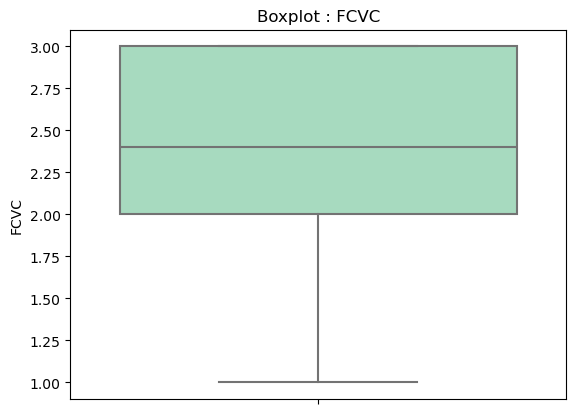

In [15]:
def check_for_imputation(data, columns):
    for c in columns:
        sns.boxplot(y = data[c],
                    color = "#9FE2BF")
        plt.title(f"Boxplot : {c}")
        plt.show()

check_for_imputation(data[num], 
                     data[num].columns[data[num].isna().any()])

> Based on the boxplot above, it is known that the **FCVC** column has no outliers, so I will perform the imputation using the **mean** value.

In [16]:
for miss_cols in data.columns[data.isna().any()]:
    if miss_cols in cat:
        data.loc[data[miss_cols].isna(), miss_cols] = data[miss_cols].dropna().mode().iloc[0]
    elif miss_cols in num:
        data.loc[data[miss_cols].isna(), miss_cols] = data[miss_cols].dropna().mean()

check_missing(data)

Missing Values Check Result:


,column name,missing values,percentage
0,Gender,0,0.0
1,Age,0,0.0
2,Height,0,0.0
3,Weight,0,0.0
4,family_history_with_overweight,0,0.0
5,FAVC,0,0.0
6,FCVC,0,0.0
7,NCP,0,0.0
8,CAEC,0,0.0
9,SMOKE,0,0.0


> Based on the missing values check above, it is known that all missing values in the data have been successfully imputed.

### DISTRIBUTION CHECK

In [17]:
data[num].describe()

,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Age
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,1.700822,86.712715,2.424559,2.663652,1.995115,0.989321,0.645499,24.273423
std,0.091582,26.198150,0.528846,0.795036,0.608807,0.853416,0.615926,6.337237
min,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,14.000000
25%,1.630000,66.125000,2.000000,2.592500,1.530000,0.110000,0.000000,20.000000
50%,1.700000,83.000000,2.424559,3.000000,2.000000,1.000000,0.585500,23.000000
75%,1.760000,108.035000,3.000000,3.000000,2.440000,1.610000,1.000000,26.000000
max,1.950000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000,55.000000


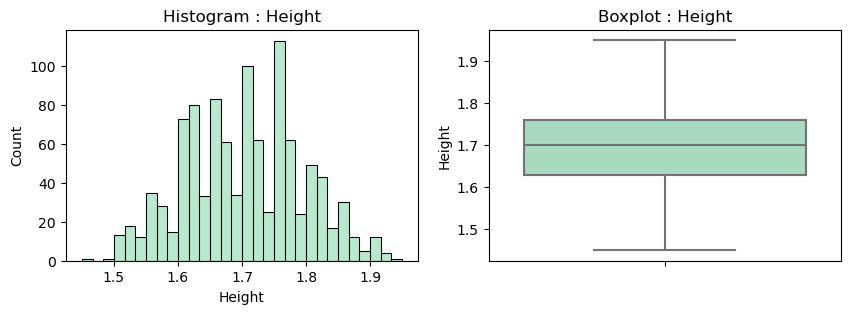

Shapiro Result: 4.985575651517138e-05


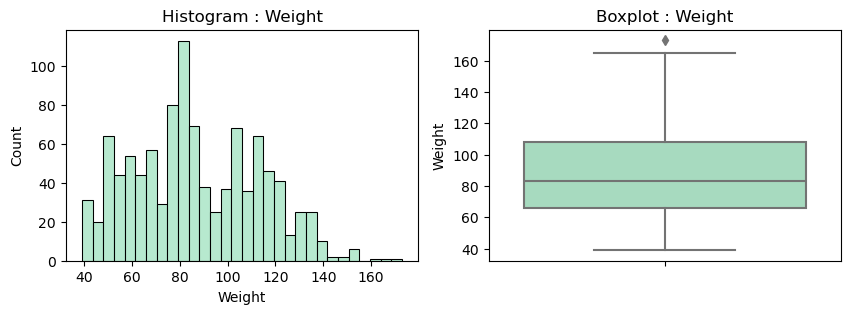

Shapiro Result: 5.312843047444726e-12


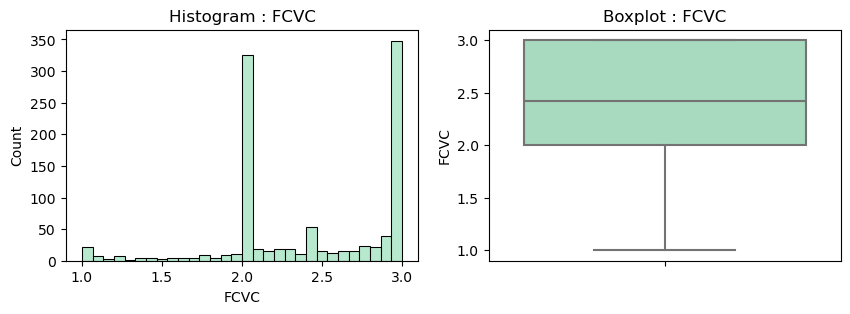

Shapiro Result: 1.828030637110641e-30


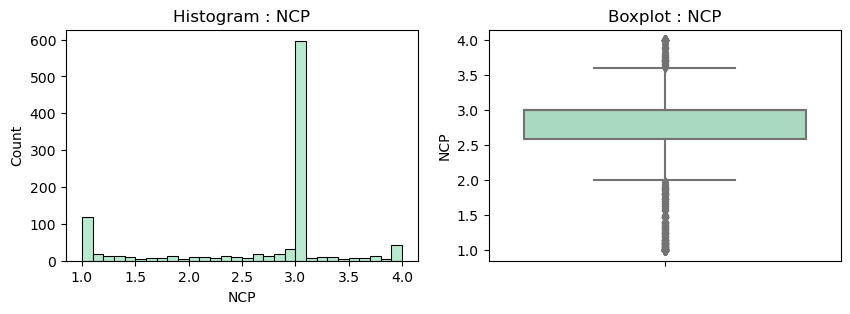

Shapiro Result: 3.7472790373617723e-37


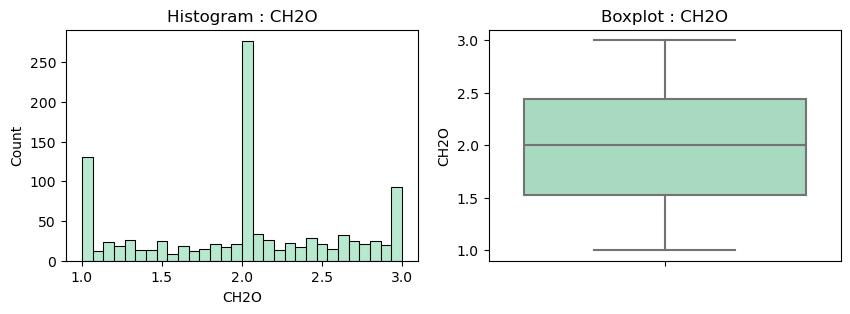

Shapiro Result: 3.0578898249266e-21


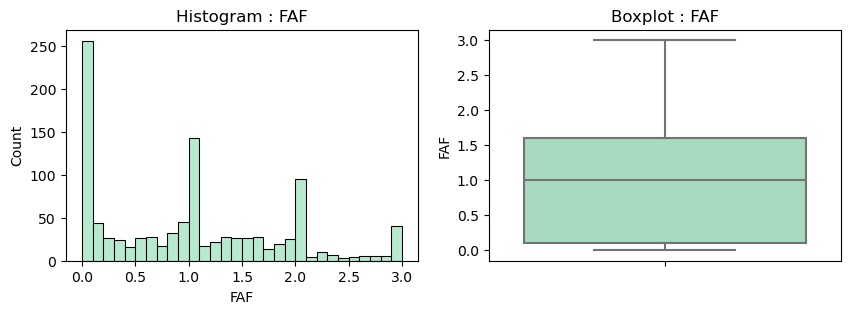

Shapiro Result: 3.2709957690655947e-24


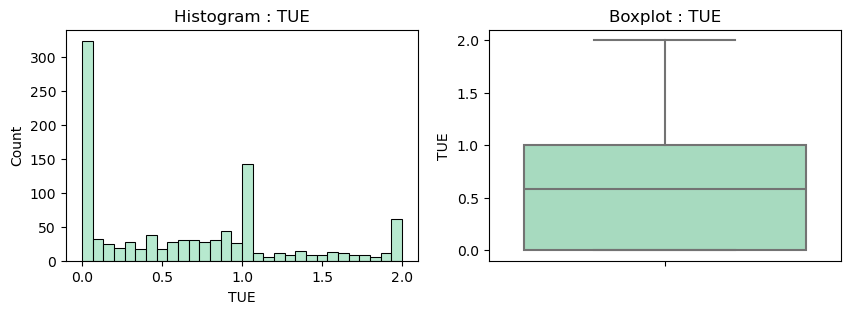

Shapiro Result: 7.111162170804517e-28


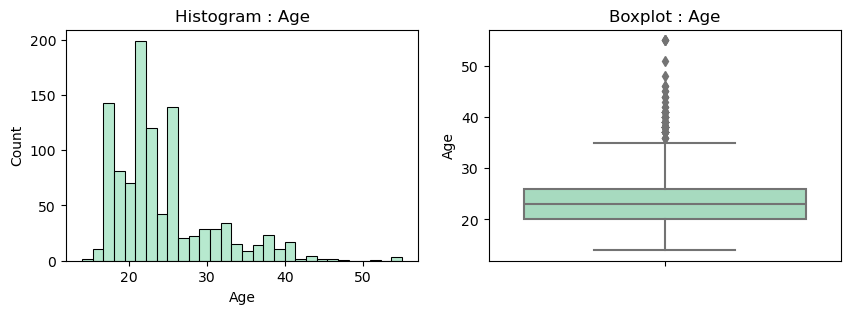

Shapiro Result: 1.4234352014852976e-28


In [18]:
# Numerical Columns
def dist_check(data, columns):
  for c in columns:
    plt.figure(figsize = (10, 3))
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[c],
                 bins = 30,
                 color = "#9FE2BF")
    plt.title(f"Histogram : {c}")
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y = data[c],
                color = "#9FE2BF")
    plt.title(f"Boxplot : {c}")

    plt.show()
    _, p_value = shapiro(data[c])
    print(f"Shapiro Result: {p_value}")
dist_check(data, num)

> Based on the distribution check on the numerical columns above, it is known that none of the numerical columns are normally distributed, which is in line with the shapiro test results not exceeding 0.05.  
> Considering that none of the numerical columns are normally distributed, the use of *StandardScaler* is not recommended.  
> Furthermore, there are several outliers in columns like **Weight**, **NCP**, and **Age**. However, these outliers are applicable in a real-world context, so I will not perform outlier handling.

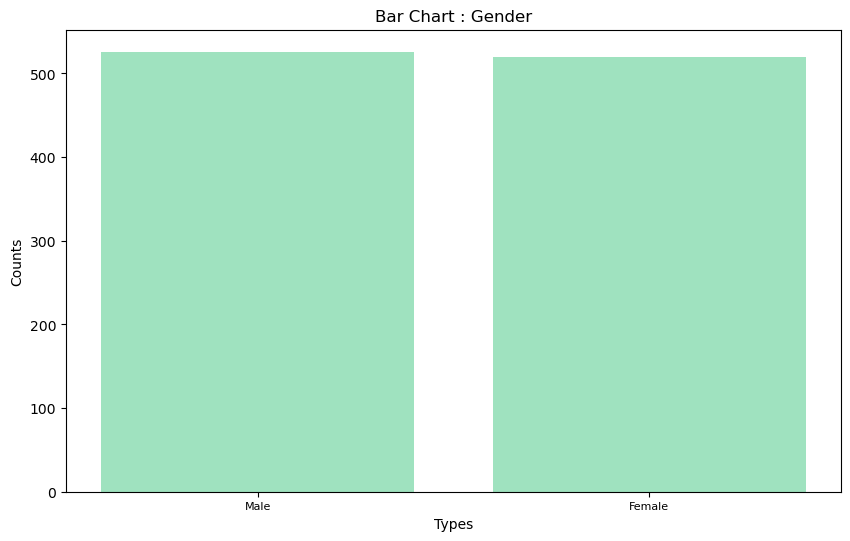

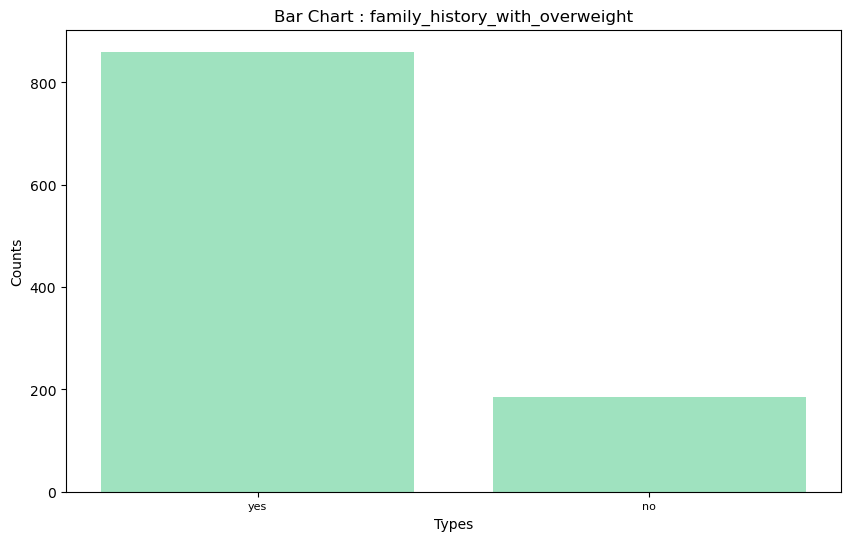

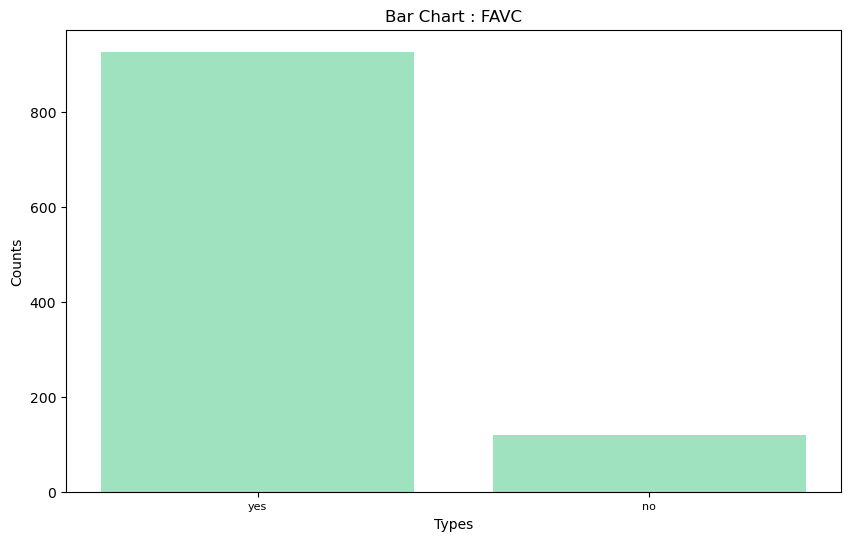

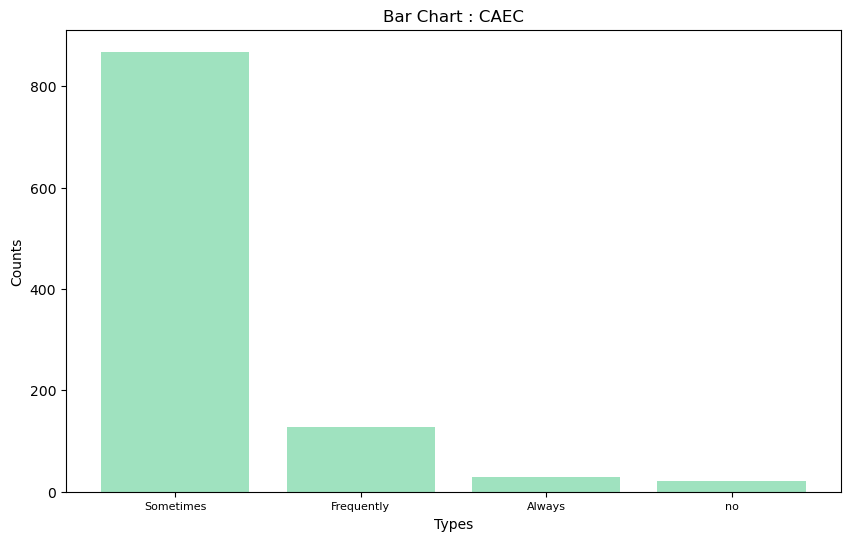

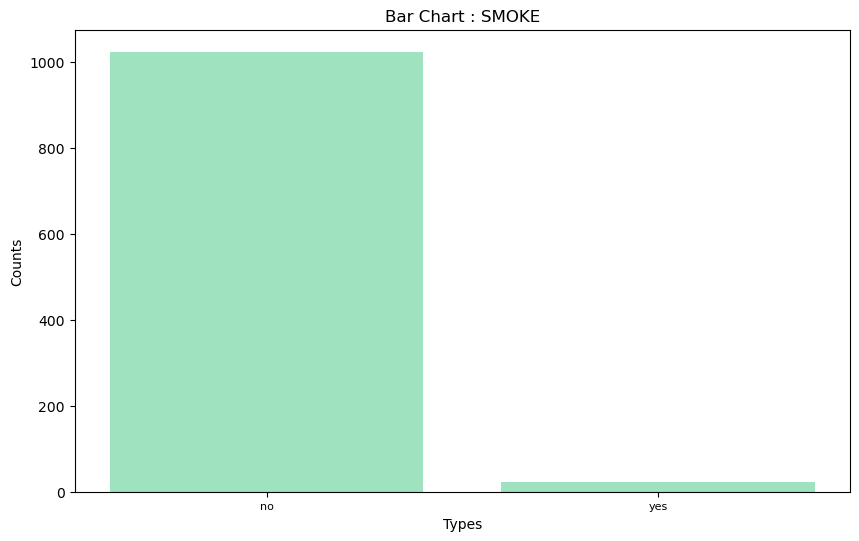

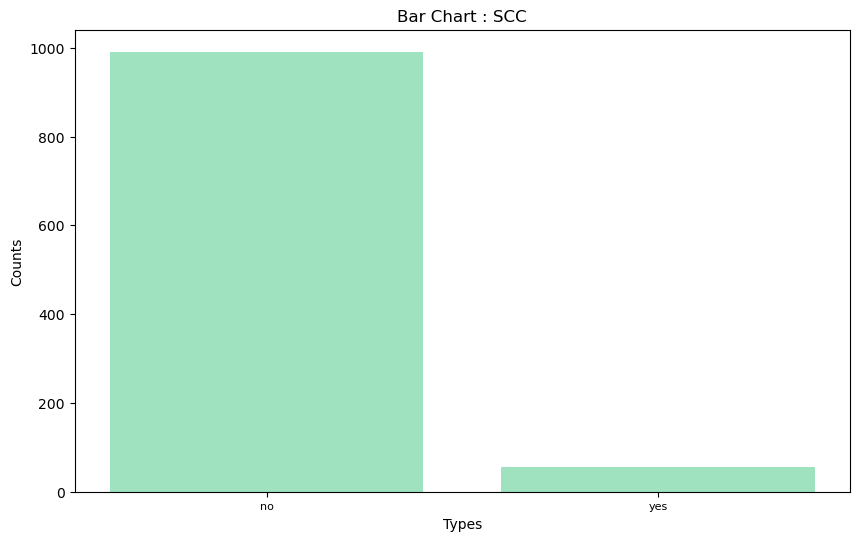

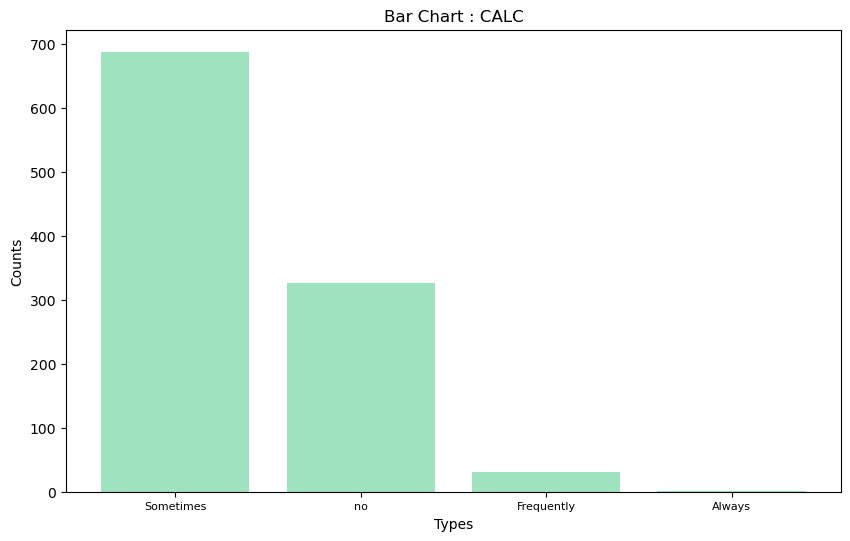

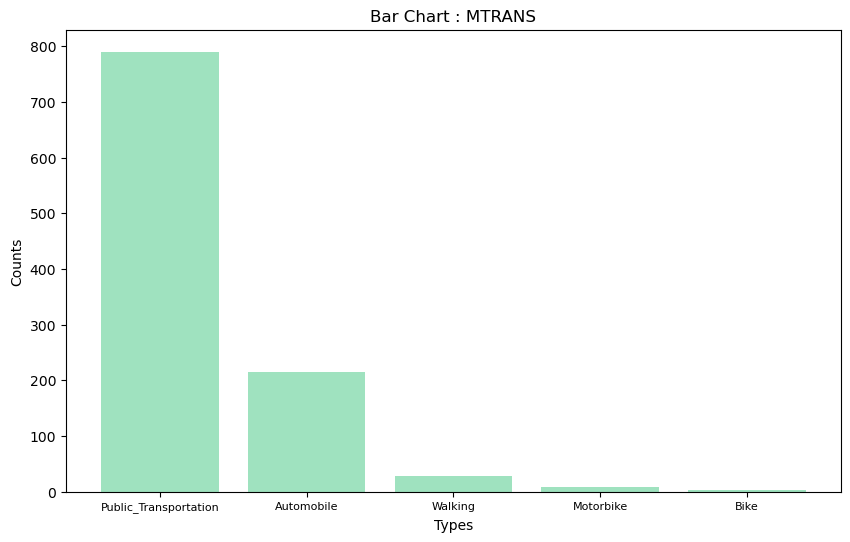

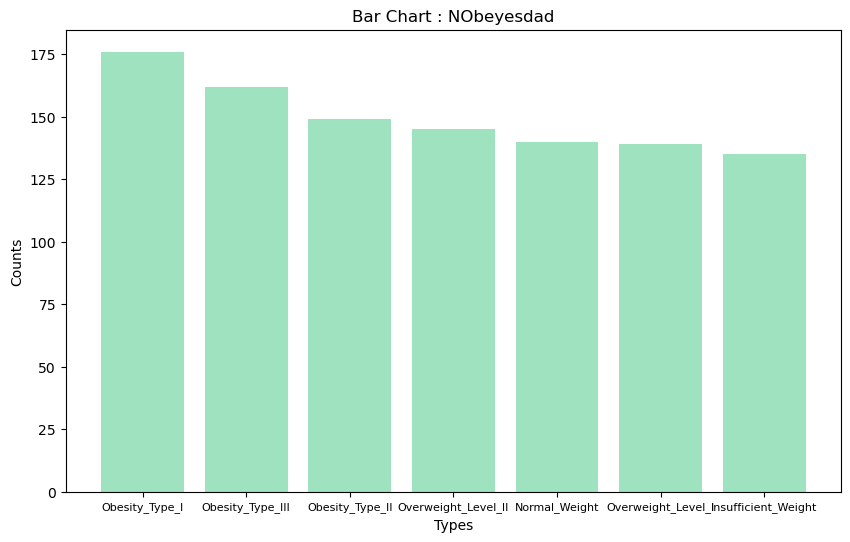

In [19]:
# Categorical Columns
def categorical_dist(df, columns):
    for c in columns:
        plt.figure(figsize = (10, 6))
    
        plt.bar(x = data[c].value_counts().index,
                height = data[c].value_counts().values,
                color = "#9FE2BF")
        plt.title(f"Bar Chart : {c}")
        plt.xlabel("Types")
        plt.ylabel("Counts")
        plt.xticks(data[c].value_counts().index,
                   fontsize = 8)
    
        plt.show()

categorical_dist(data, cat)

> Based on the distribution check on the categorical columns above, it is known that:
> - **Gender**: the data is balanced between males and females.
> - **family_history_with_overweight**: the majority of individuals have a family with a history of overweight.
> - **FAVC**: the majority of individuals frequently consume high-calorie foods.
> - **CAEC**: the majority of individuals sometimes eat between meals.
> - **SMOKE**: the majority of individuals do not smoke.
> - **SCC**: the majority of individuals do not track their daily calorie intake.
> - **CALC**: the majority of individuals sometimes drink alcohol.
> - **MTRANS**: the majority of individuals use public transportation in their daily lives.
> - **NObeyesdad**: the majority of individuals experience obesity, whether it is Type I, II, or III.

### CORRELATION CHECK

In [20]:
order = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III"
]

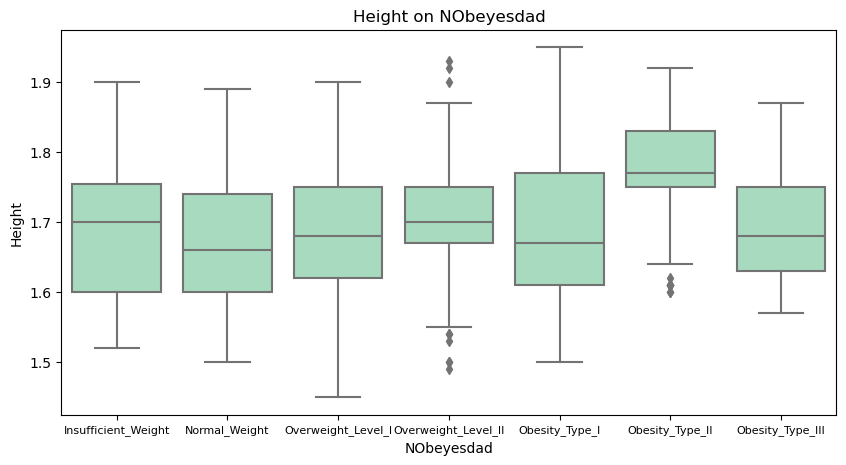

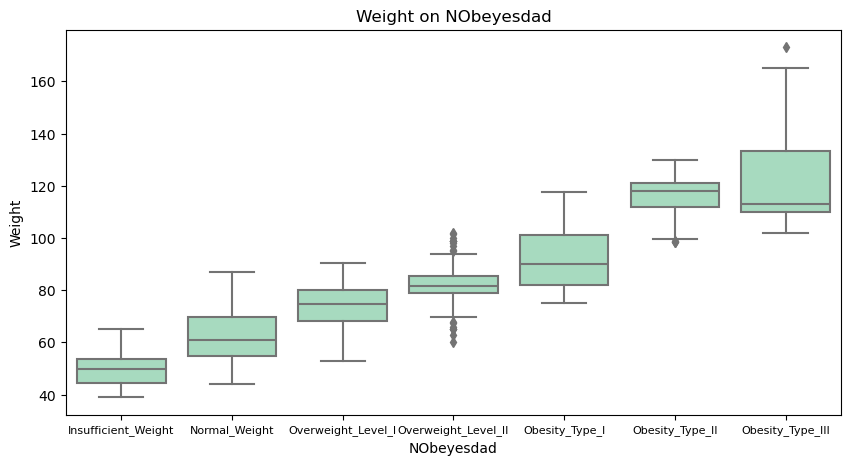

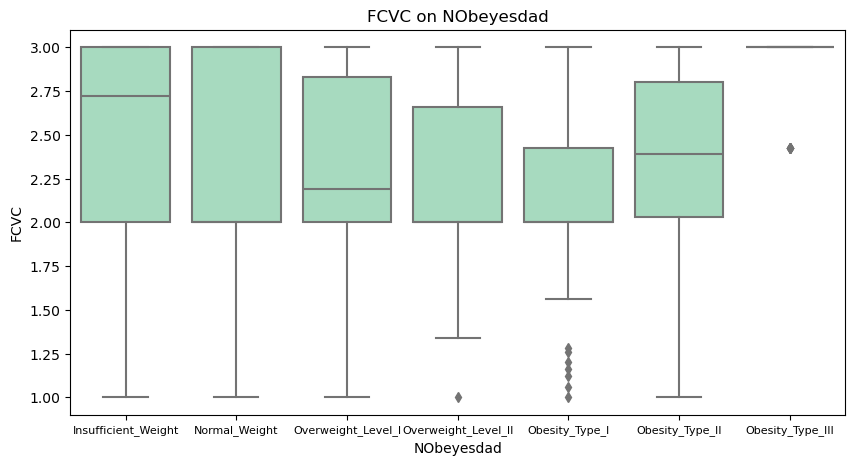

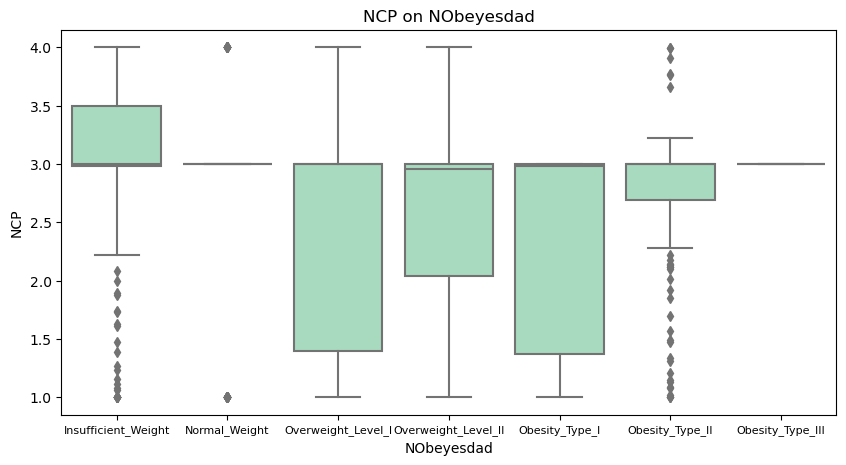

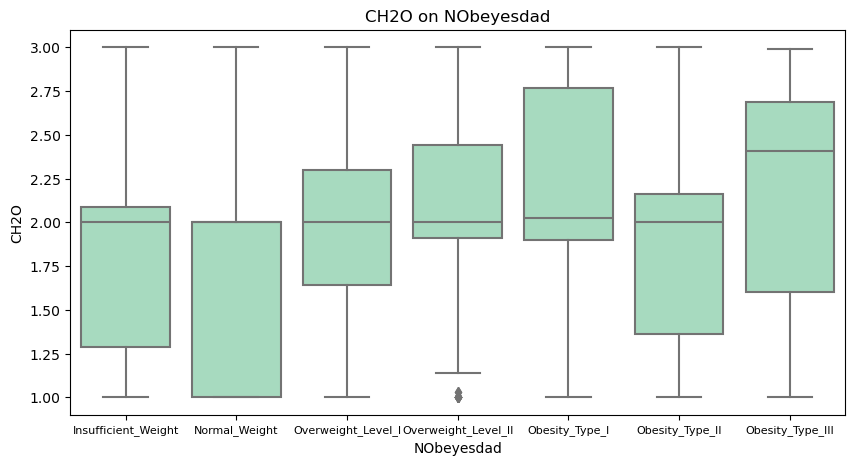

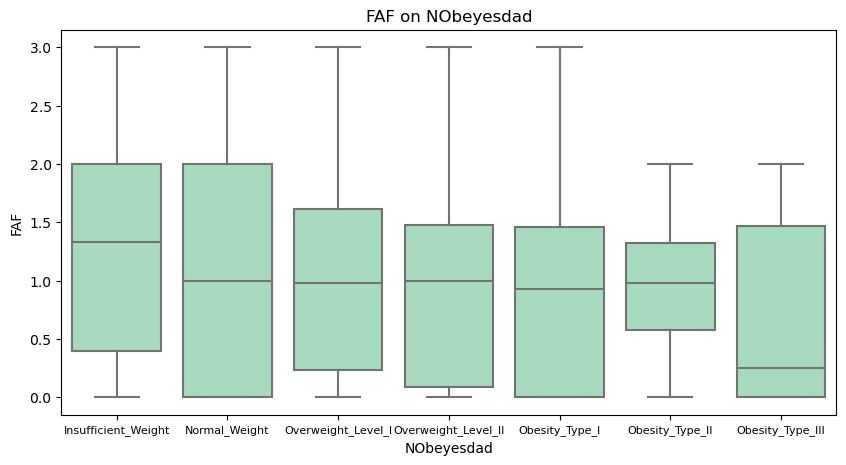

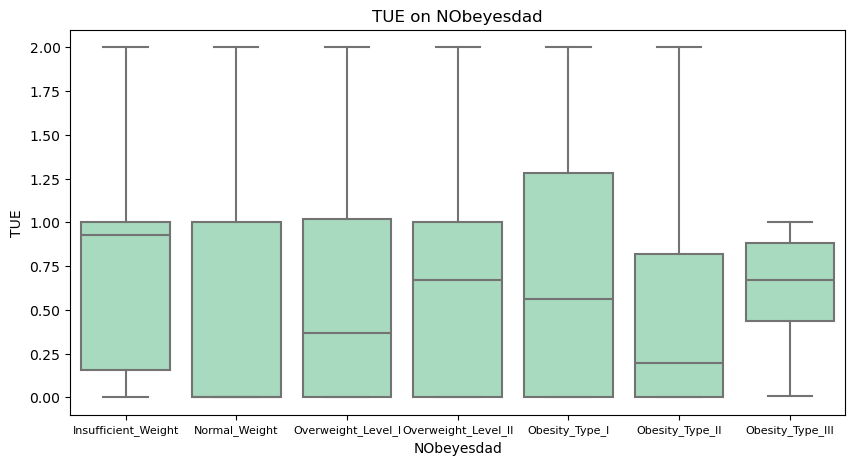

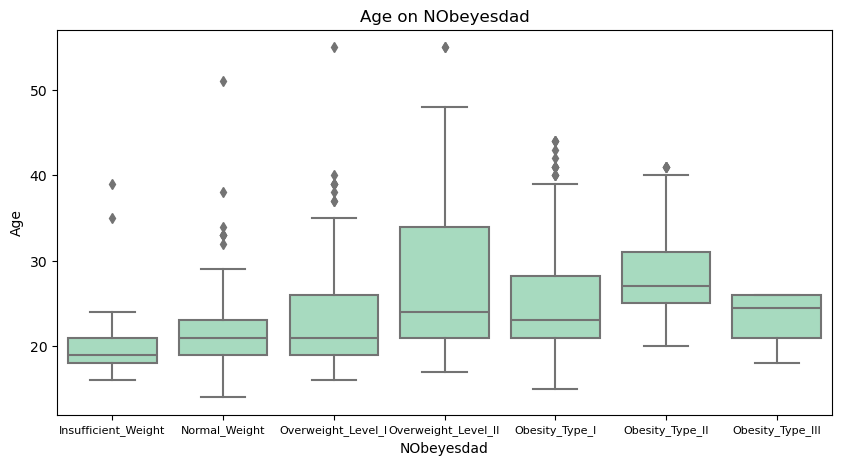

In [21]:
def num_with_y(data, cols, target, order = None):
    for c in cols:
        plt.figure(figsize = (10, 5))
    
        sns.boxplot(x = data[target],
                    y = data[c],
                    order = order,
                    color = "#9FE2BF")
        plt.title(f"{c} on {target}")
        plt.xticks(fontsize = 8)
        plt.show()
        
num_with_y(data,
           num,
           "NObeyesdad",
           order)

> Based on the correlation check between the numerical variables and **NObeyesdad** (target), it is found that:
> - **Height**: there is no significant correlation between height and an individual's obesity status. This logically contradicts the fact that height and weight are significant factors for a person's obesity level.
> - **Weight**: weight has a fairly clear correlation with a person's obesity level, where individuals with a greater weight tend to be classified in a higher obesity level.
> - **FCVC**: there is no significant correlation between the frequency of a person's vegetable consumption and their obesity level.
> - **NCP**: interestingly, the number of main meals per day is not a significantly influential factor on a person's obesity level.
> - **CH2O**: in general, there is no significant correlation between a person's daily water intake and their obesity level.
> - **FAF**: although not significantly apparent, the frequency of physical activity does influence a person's obesity level. This is visible as individuals with *Obesity Type III* tend to engage in physical activity less frequently than individuals with *Insufficient* or *Normal Weight*.
> - **TUE**: the amount of time spent using technology does not significantly influence a person's obesity level.
> - **Age**: there is no significant correlation between a person's age and their obesity level.

<Figure size 1000x500 with 0 Axes>

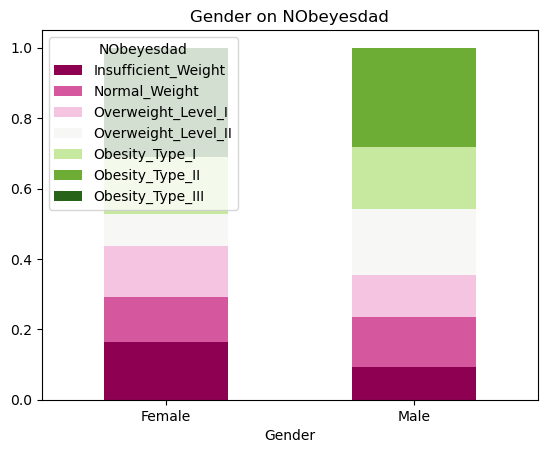

<Figure size 1000x500 with 0 Axes>

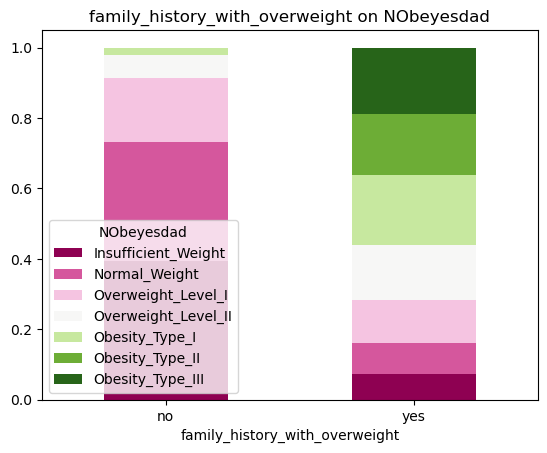

<Figure size 1000x500 with 0 Axes>

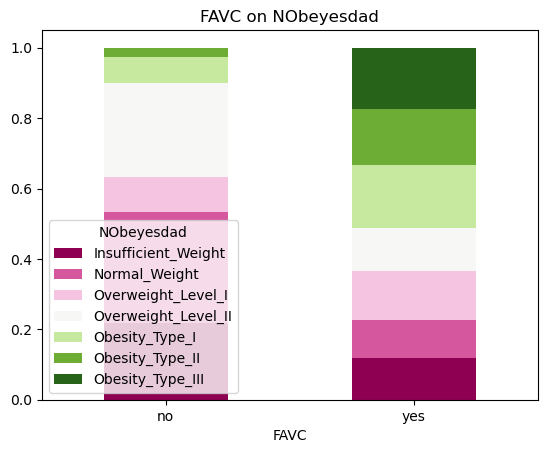

<Figure size 1000x500 with 0 Axes>

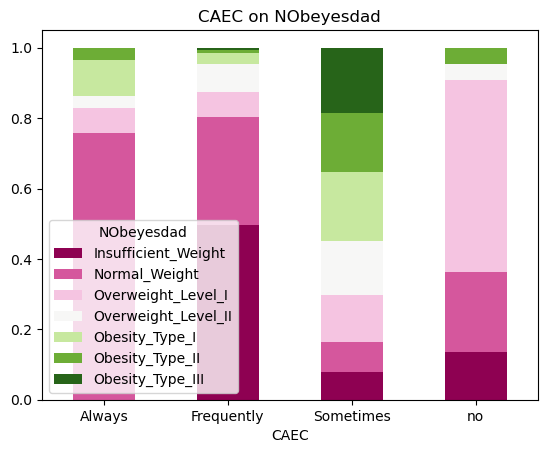

<Figure size 1000x500 with 0 Axes>

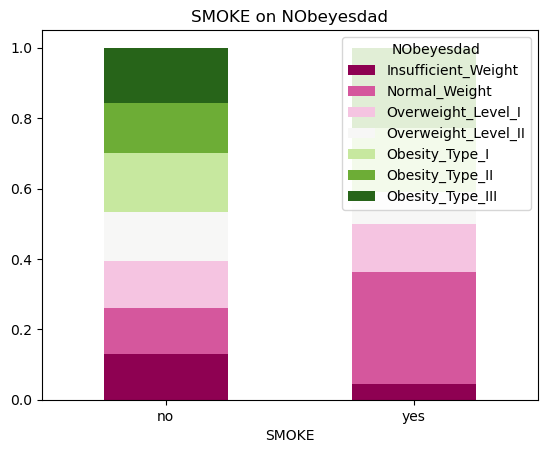

<Figure size 1000x500 with 0 Axes>

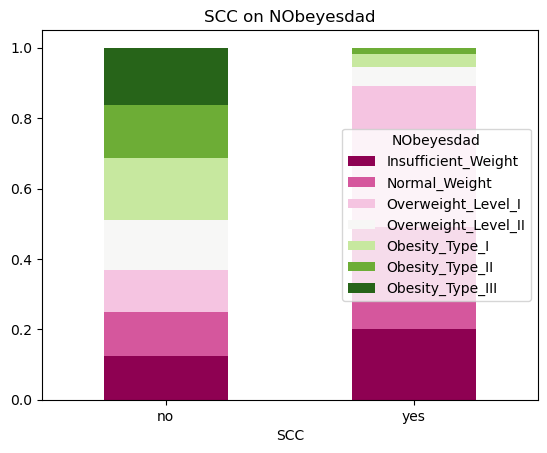

<Figure size 1000x500 with 0 Axes>

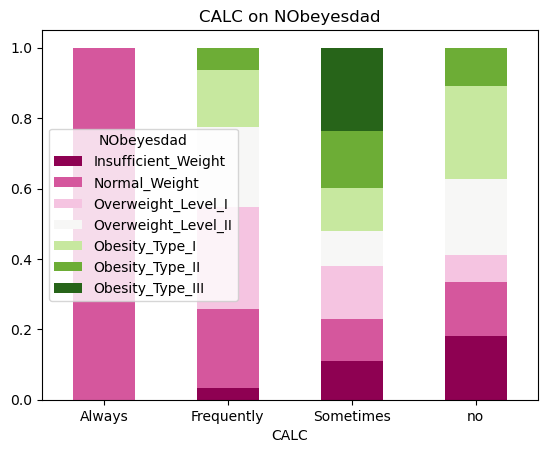

<Figure size 1000x500 with 0 Axes>

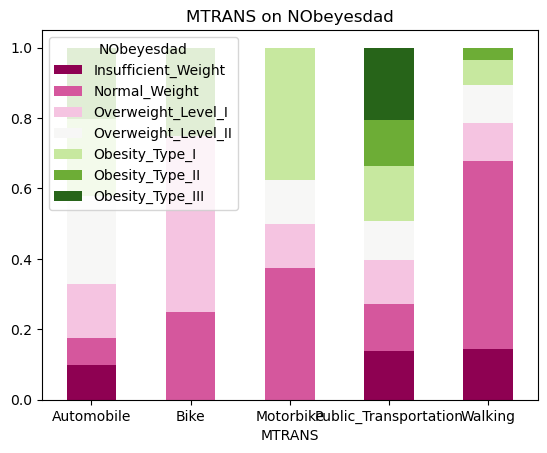

In [22]:
cat_wo_y = cat.copy()
def cat_with_y(data, cols, target, order = None):
    cat_wo_y.remove(target)
    for c in cols:
        plt.figure(figsize = (10, 5))
    
        grouped_data = data.groupby(c)[target].value_counts(normalize = True).unstack(target)

        if order:
            grouped_data = grouped_data.reindex(columns = order)

        grouped_data.plot.bar(stacked = True, cmap = "PiYG")
        plt.title(f"{c} on {target}")
        plt.xticks(rotation = 0)
    
        plt.show()

cat_with_y(data,
           cat_wo_y,
           "NObeyesdad",
           order)

> Based on the correlation check between the categorical variables and **NObeyesdad** (target), it is found that:
> - **Gender**: there is no significant correlation between a person's gender and their obesity level.
> - **family_history_with_overweight**: individuals with a family history of being overweight tend to be more prone to experiencing the same.
> - **FAVC**: individuals who consume high-calorie foods tend to be at risk of experiencing obesity
> - **CAEC**: eating between meals does not significantly affect an individual's obesity level.
> - **SMOKE**: smoking does not have a very significant effect on a person's obesity level.
> - **SCC**: individuals who monitor their calorie intake tend to avoid obesity.
> - **CALC**: alcohol intake does not significantly affect a person's obesity level.
> - **MTRANS**: individuals who walk as their main mode of transportation tend to avoid obesity.

> To prove my interpretation above, I will perform a correlation check on the numerical features using a heatmap.

In [23]:
target_enc = {
    "NObeyesdad": {
        "Insufficient_Weight": 0,
        "Normal_Weight": 1,
        "Overweight_Level_I": 2,
        "Overweight_Level_II": 3,
        "Obesity_Type_I": 4,
        "Obesity_Type_II": 5,
        "Obesity_Type_III": 6
    }
}
data = data.replace(target_enc)
print("Ordinal Encoding on NObeyesdad performed.")

Ordinal Encoding on NObeyesdad performed.


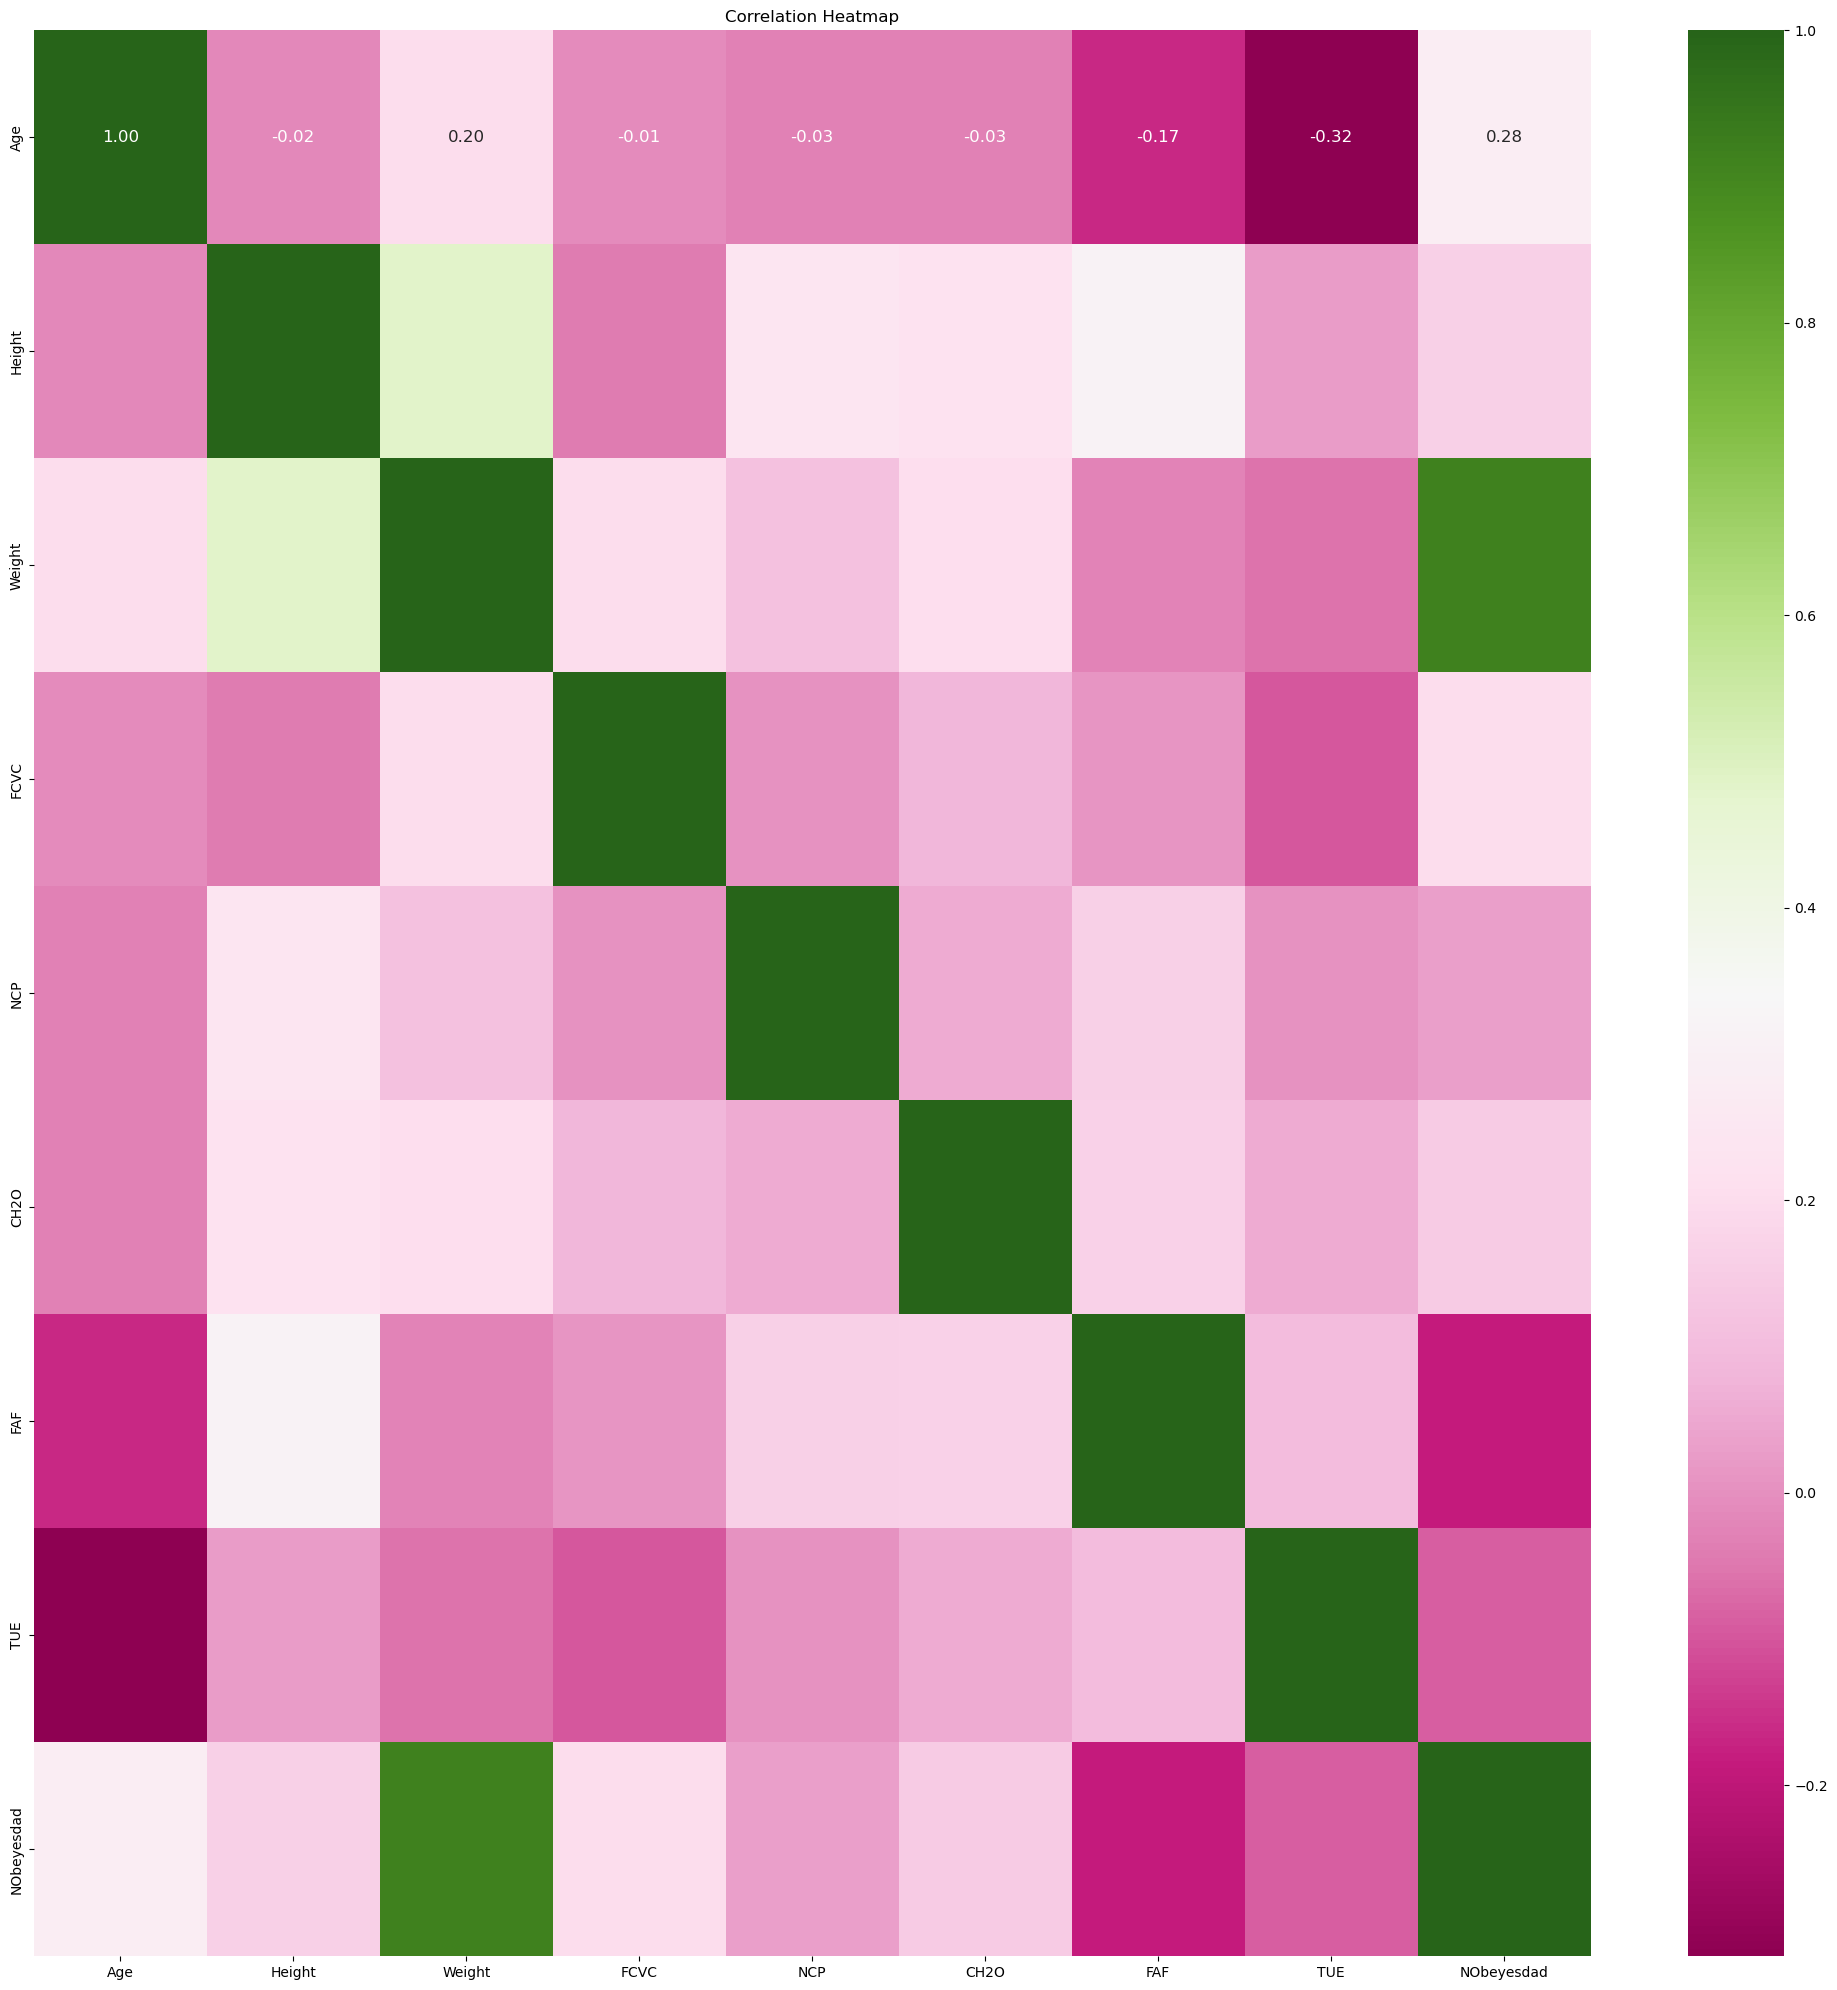

In [24]:
def heatmap(data):
    temp_data = data.select_dtypes(include = ["number"])
    plt.figure(figsize = (20, 20))
    sns.heatmap(temp_data.corr(),
                annot = True,
                annot_kws = {"size": 12},
                cmap = "PiYG",
                fmt = ".2f",
                cbar = True)
    plt.title("Correlation Heatmap")
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

heatmap(data)

> Based on the heatmap above, it is known that the numerical features that correlate with **NObeyesdad** are **Weight** and **FAF**.  
> Considering the fact that **Height** should also play a significant role in a person's obesity level, I will perform feature engineering for **BMI**, because BMI is the most commonly used indicator to identify a person's obesity level.

#### FEATURE ENGINEERING

In [25]:
data["BMI"] = data["Weight"] / (data["Height"] ** 2)
num.append("BMI")

print("BMI column created.")

BMI column created.


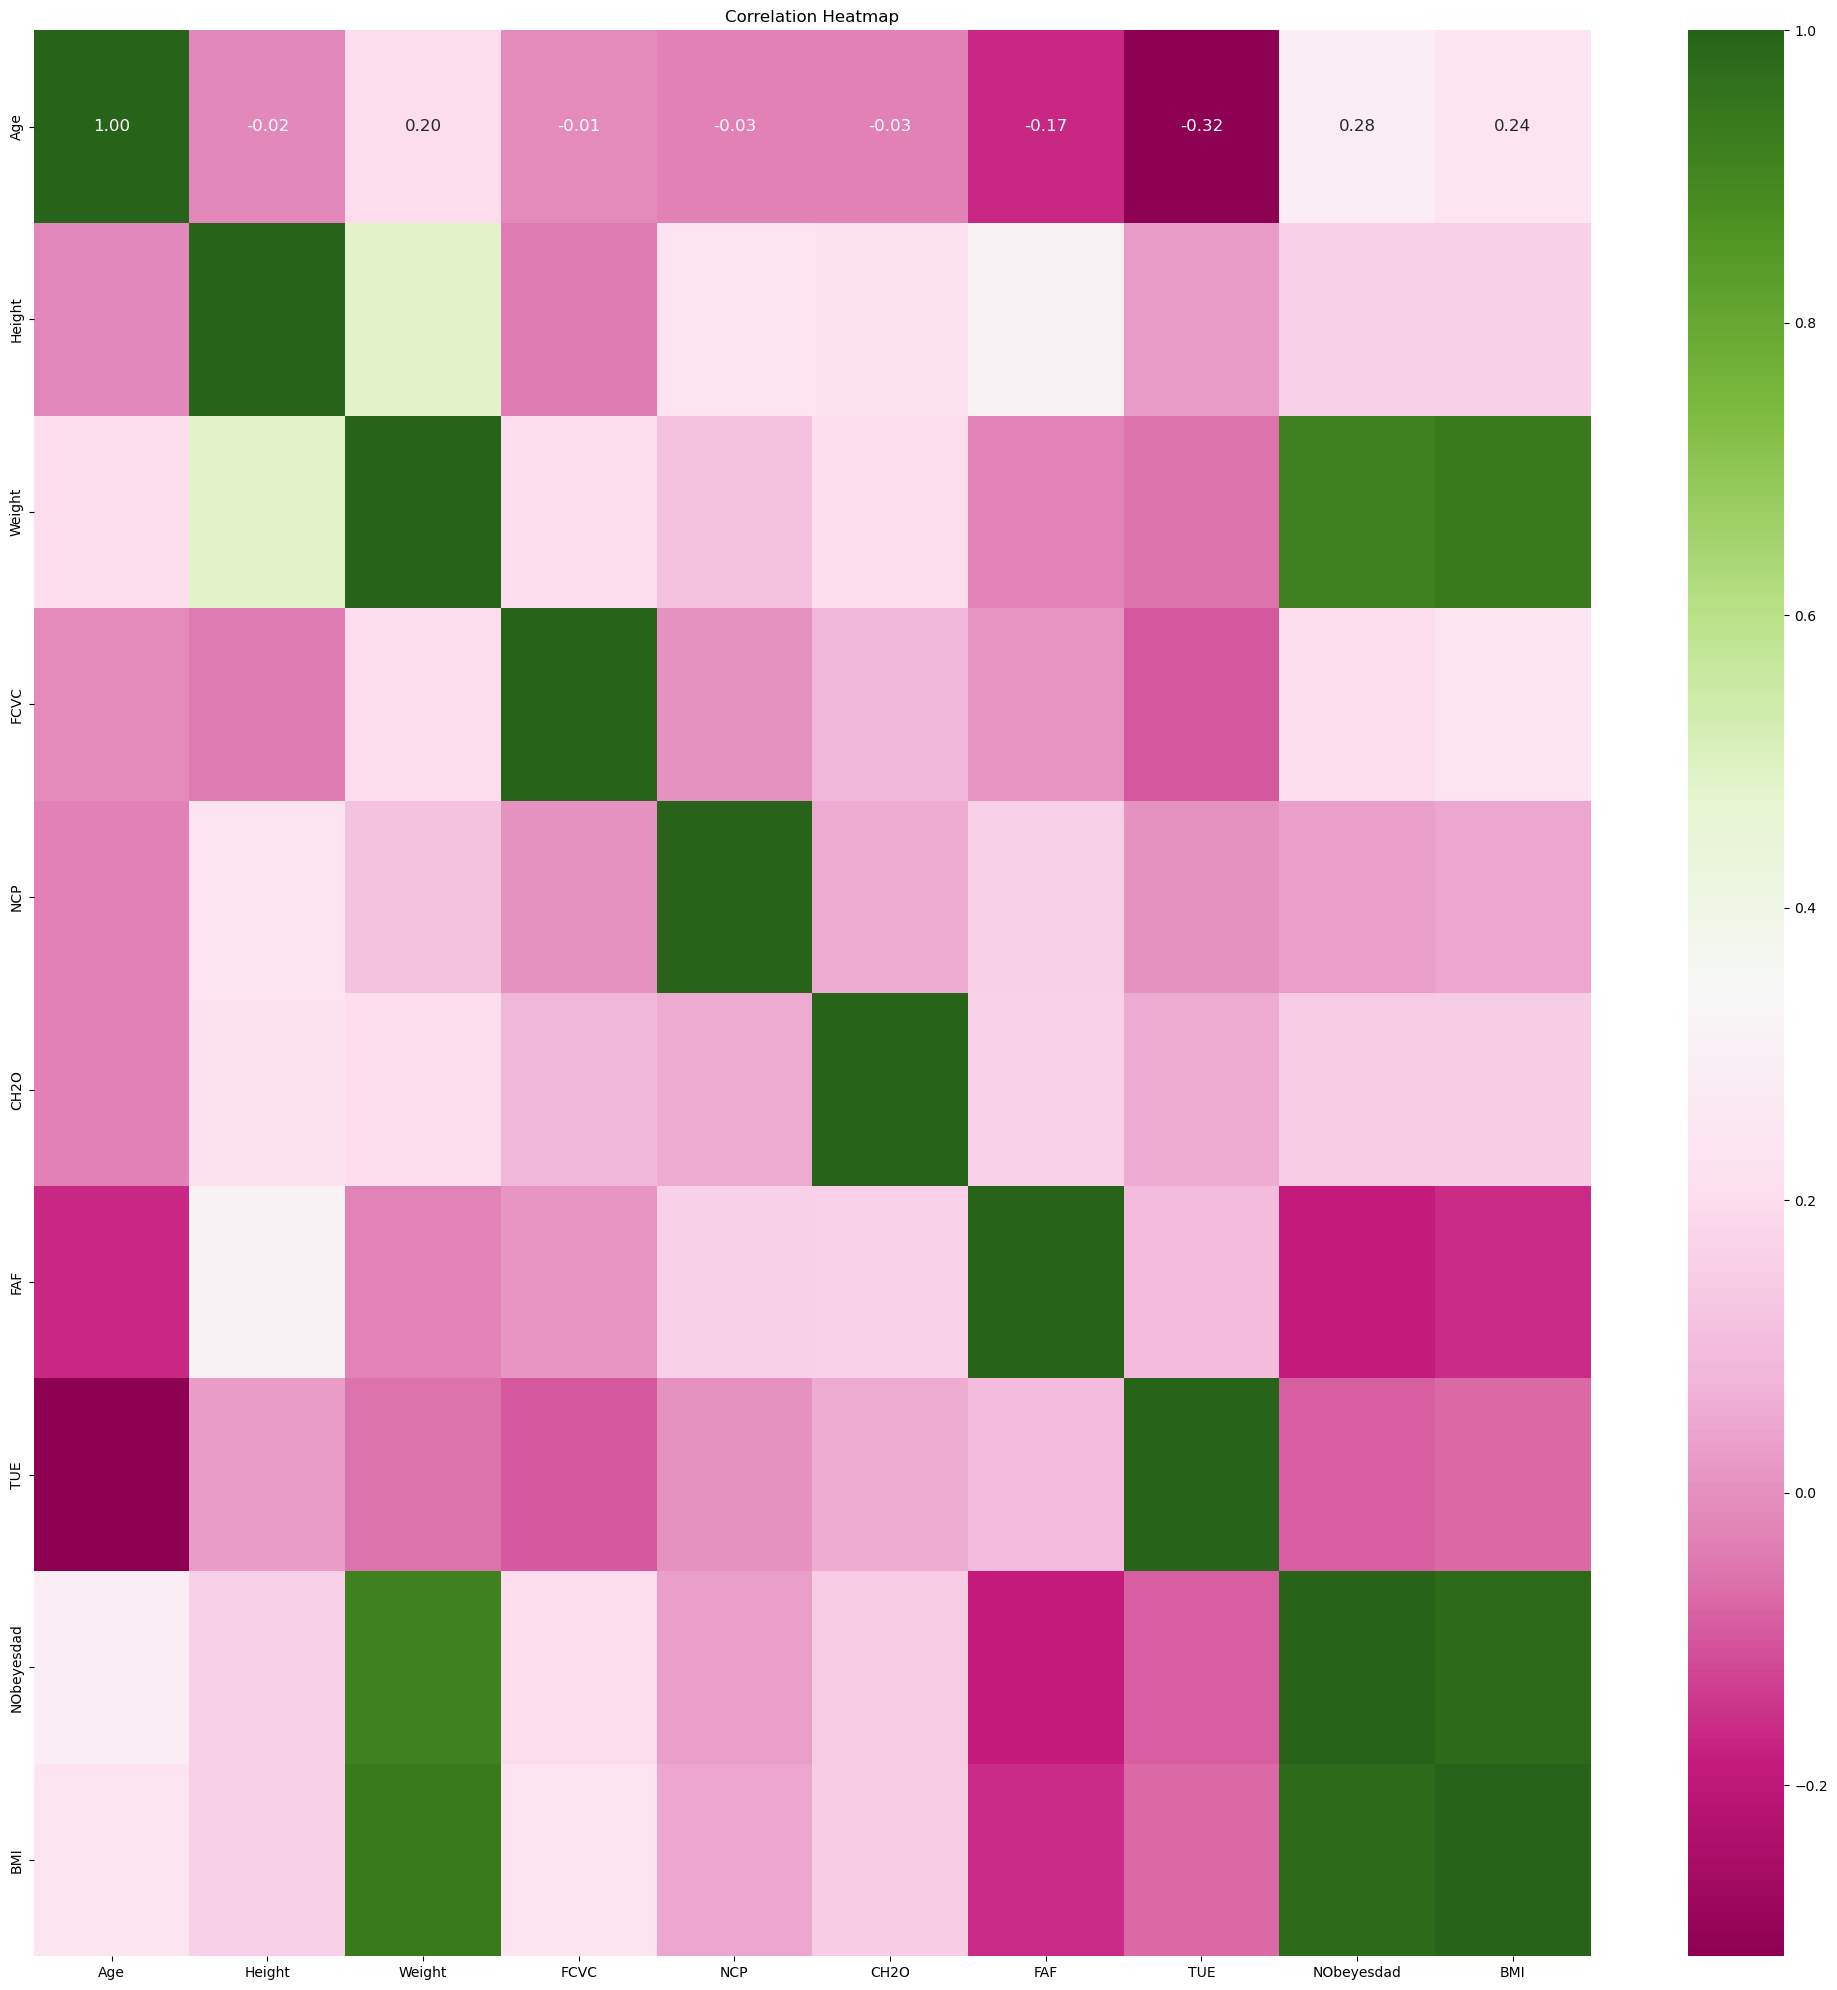

In [26]:
heatmap(data)

> Based on the heatmap above, it is known that **BMI** plays a very significant role in relation to **NObeyesdad**.

### ENCODING

In [27]:
for c in cat:
    print(data[c].value_counts(),
          '\n')

Gender
Male      526
Female    520
Name: count, dtype: int64 

family_history_with_overweight
yes    860
no     186
Name: count, dtype: int64 

FAVC
yes    926
no     120
Name: count, dtype: int64 

CAEC
Sometimes     868
Frequently    127
Always         29
no             22
Name: count, dtype: int64 

SMOKE
no     1024
yes      22
Name: count, dtype: int64 

SCC
no     991
yes     55
Name: count, dtype: int64 

CALC
Sometimes     688
no            326
Frequently     31
Always          1
Name: count, dtype: int64 

MTRANS
Public_Transportation    790
Automobile               216
Walking                   28
Motorbike                  8
Bike                       4
Name: count, dtype: int64 

NObeyesdad
4    176
6    162
5    149
3    145
1    140
2    139
0    135
Name: count, dtype: int64 



> Based on the output above, it is known that the **Gender**, **family_history_with_overweight**, **FAVC**, **SMOKE**, and **SCC** columns are binary, or only have 2 unique values, so I will use binary encoding for these columns.  
> Next, the **CAEC** and **CALC** columns are ordinal columns, because they have a clear hierarchy, namely "no", "Sometimes", "Frequently", "Always". Therefore, I will perform ordinal encoding according to the existing order.  
> The **MTRANS** column cannot be considered ordinal, because there is no clear hierarchy. Then, considering the insight from the [**CORRELATION CHECK**](#CORRELATION-CHECK) section that only individuals who walk are significant, I will change the **MTRANS** column to be binary, and then perform binary encoding on this column.

In [28]:
data["MTRANS"] = data["MTRANS"].map(lambda x: "Walking" if x == "Walking" else "Not_Walking")

In [29]:
bin_enc = {
    "Gender": {
        "Male": 0,
        "Female": 1
    },
    "family_history_with_overweight": {
        "no": 0,
        "yes": 1
    },
    "FAVC": {
        "no": 0,
        "yes": 1
    },
    "SMOKE": {
        "no": 0,
        "yes": 1
    },
    "SCC": {
        "no": 0,
        "yes": 1
    },
    "MTRANS": {
        "Walking": 1,
        "Not_Walking": 0
    }
}
data = data.replace(bin_enc)
print("Binary Encoding performed.")

Binary Encoding performed.


In [30]:
ord_enc = {
    "CAEC": {
        "no": 0,
        "Sometimes": 1,
        "Frequently": 2,
        "Always": 3
    },
    "CALC": {
        "no": 0,
        "Sometimes": 1,
        "Frequently": 2,
        "Always": 3
    }
}
data = data.replace(ord_enc)
print("Ordinal Encoding performed.")

Ordinal Encoding performed.


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1046 non-null   int64  
 1   Age                             1046 non-null   int32  
 2   Height                          1046 non-null   float64
 3   Weight                          1046 non-null   float64
 4   family_history_with_overweight  1046 non-null   int64  
 5   FAVC                            1046 non-null   int64  
 6   FCVC                            1046 non-null   float64
 7   NCP                             1046 non-null   float64
 8   CAEC                            1046 non-null   int64  
 9   SMOKE                           1046 non-null   int64  
 10  CH2O                            1046 non-null   float64
 11  SCC                             1046 non-null   int64  
 12  FAF                             10

In [32]:
check_unique_values(data)

Cardinality Check Result:


,column name,data type,unique values,values,minimum value,maximum value
0,Gender,int64,2,"[0, 1]",0.000000,1.000000
1,Age,int32,36,"[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...",14.000000,55.000000
2,Height,float64,47,"[1.45, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55...",1.450000,1.950000
3,Weight,float64,715,"[39.0, 39.1, 39.7, 41.32, 41.45, 41.56, 41.67,...",39.000000,173.000000
4,family_history_with_overweight,int64,2,"[0, 1]",0.000000,1.000000
5,FAVC,int64,2,"[0, 1]",0.000000,1.000000
6,FCVC,float64,148,"[1.0, 1.04, 1.05, 1.06, 1.07, 1.08, 1.11, 1.12...",1.000000,3.000000
7,NCP,float64,194,"[1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07...",1.000000,4.000000
8,CAEC,int64,4,"[0, 1, 2, 3]",0.000000,3.000000
9,SMOKE,int64,2,"[0, 1]",0.000000,1.000000


> Here, it is known that all categorical columns have been encoded into numerical values to facilitate the modelling process.

### DATA SPLITTING

In [33]:
x = data[data.columns.drop(["NObeyesdad"])]
y = data["NObeyesdad"]

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 11)

print("Data splitted.")

Data splitted.


### SCALING

> Based on the insights gained previously, I will use *RobustScaler*, because *RobustScaler* is not sensitive to outliers.

In [34]:
robust = RobustScaler()
x_train[num] = robust.fit_transform(x_train[num])
x_test[num] = robust.transform(x_test[num])
print("Scaling performed.")

Scaling performed.


### MODELLING AND EVALUATION

#### RANDOM FOREST

> In the first model, I am using a Random Forest model with:
> - **n_estimators** = 100
> - **max_depth** = 11
> - **min_samples_split** = 5
> - **criterion** = "gini"

In [35]:
model_rf = RandomForestClassifier(n_estimators = 100,
                                  max_depth = 11,
                                  min_samples_split = 5,
                                  criterion = "gini",
                                  random_state = 11)

model_rf.fit(x_train,
             y_train)
ypred_rf = model_rf.predict(x_test)
print("Random Forest Model.")

Random Forest Model.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.91      0.95      0.93        43
           2       0.92      0.88      0.90        50
           3       0.93      0.95      0.94        39
           4       1.00      0.98      0.99        54
           5       1.00      1.00      1.00        44
           6       1.00      1.00      1.00        44

    accuracy                           0.96       314
   macro avg       0.96      0.97      0.97       314
weighted avg       0.97      0.96      0.96       314

    0   1   2   3   4   5   6
0  40   0   0   0   0   0   0
1   0  41   2   0   0   0   0
2   0   4  44   2   0   0   0
3   0   0   2  37   0   0   0
4   0   0   0   1  53   0   0
5   0   0   0   0   0  44   0
6   0   0   0   0   0   0  44


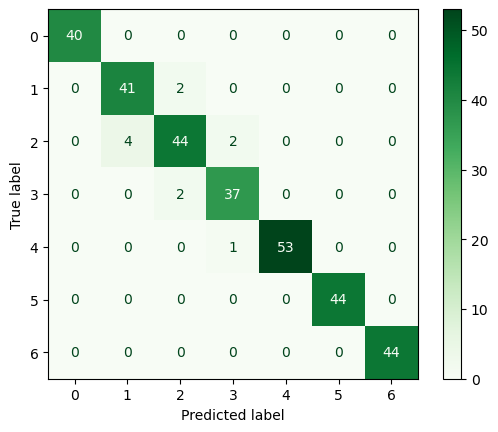

In [36]:
print(f"Classification Report:")
print(classification_report(y_test,
                            ypred_rf))
print(pd.DataFrame(confusion_matrix(y_test,
                                    ypred_rf)))
cm_rf = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                   ypred_rf),
                               display_labels = model_rf.classes_)
cm_rf.plot(cmap = "Greens")

> Based on the classification report above, it is known that the accuracy of my Random Forest model is 96%.
> - ***Precision*** of 0.96 indicates that 96% of the predicted values are the actual values (true positive).
> - ***Recall*** of 0.97 shows that 97% of the data was correctly predicted.
> - ***F1-Score*** of 0.97 signifies the overall performance of the model, which is a combination of precision and recall.
> 
> Furthermore, based on the confusion matrix, it is known that the model only made prediction errors that were still close to the actual class, so the model's performance can be considered very good.

#### XGBOOST

> In the second model, I am using an XGBoost model with:
> - **n_estimators** = 100
> - **learning_rate** = 0.9
> - **max_depth** = 10
> - **eval_metric** = "logloss"

In [37]:
model_xgb = XGBClassifier(n_estimators = 100,
                          learning_rate = 0.9,
                          max_depth = 10,
                          eval_metric = "logloss")

model_xgb.fit(x_train,
              y_train)
ypred_xgb = model_xgb.predict(x_test)
print("XGBoost Model.")

XGBoost Model.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.95      0.94        43
           2       0.94      0.90      0.92        50
           3       0.93      0.97      0.95        39
           4       1.00      0.98      0.99        54
           5       1.00      1.00      1.00        44
           6       1.00      1.00      1.00        44

    accuracy                           0.97       314
   macro avg       0.97      0.97      0.97       314
weighted avg       0.97      0.97      0.97       314

    0   1   2   3   4   5   6
0  40   0   0   0   0   0   0
1   0  41   2   0   0   0   0
2   0   3  45   2   0   0   0
3   0   0   1  38   0   0   0
4   0   0   0   1  53   0   0
5   0   0   0   0   0  44   0
6   0   0   0   0   0   0  44


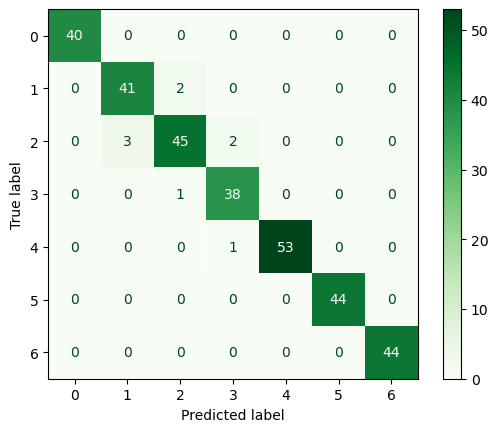

In [38]:
print(f"Classification Report:")
print(classification_report(y_test,
                            ypred_xgb))
print(pd.DataFrame(confusion_matrix(y_test,
                                    ypred_xgb)))
cm_xgb = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                    ypred_xgb),
                               display_labels = model_xgb.classes_)
cm_xgb.plot(cmap = "Greens")

> Based on the classification report above, the accuracy of the XGBoost model I used is 97%.
> - ***Precision*** of 0.97 indicates that 97% of the predicted values are the actual values (true positive).
> - ***Recall*** of 0.97 shows that 97% of the data was correctly predicted.
> - ***F1-Score*** of 0.97 signifies the overall model performance, which is a combination of precision and recall.
>
> Furthermore, based on the confusion matrix, it can also be seen that the model's predictions are slightly better than the Random Forest model, because it tends to make fewer prediction errors.

### SUMMARY

> Based on the evaluation results of both models, namely the Random Forest and XGBoost models, it was found that both models can predict an individual's obesity level very well.  
> Therefore, I am choosing to use the XGBoost model, due to its slightly better performance compared to the Random Forest model.